# Milestone 3 
 
#### Objective:

 - Build a model with algorithmic gender bias. Using SHAP, AIF-360, and manual calculations, detect algorithmic bias. Then, using AIF-360, mitigate the bias you detected.

#### Workflow:

 - Load data
 - Train a model without unwanted gender bias
 - Demonstrate using confusion matrices that the model is not significantly biased
 - Manually measure equal opportuity difference and disparate impact
 - Introduce bias into the data
 - Train a biased model
 - Demonstrate using confusion matrices that the model is significantly biased
 - Manually measure equal opportunity difference and disparate impact
 - Use SHAP explainer to explain the model's underlying predictions
 - Load the dataset into AIF360
 - Debias the model using Reweighing and measure the remaining bias
 - Debias the model using Disparate Impact Remover and measure the remaining bias
 - Debias the model using Calibrated Equal Odds Postprocessing and measure the remaining bias
 - Choose one of the approaches, recommend it for use, and explain why
 - Fine-tune your Reweighing and Disparate Impact Remover approaches by selecting the best possible threshold

#### Importance to Project:

 - In the scenario of this LiveProject, you are called upon to detect and/or mitigate unwanted bias in three models (and their corresponding datasets) for the WHO. Here we work with two models - one which probably does not have unwanted bias, and one which does. In these cases, the protected class data is available. For our final model, in Milestone 4, it is not available. 
 - Most of the work here is done on the model which does have unwanted bias. We want to measure that bias and try and mitigate it. The workflow guides you through that process.
 
#### Resources:
 - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6678298/ (a description of the original dataset and its use)
 - https://arxiv.org/pdf/1810.01943.pdf (the original AIF360 paper, which describes several methods for debiasing implemented within the package)
 - https://aif360.mybluemix.net/data (a demo of AIF360. Here, we are unpacking what is done at the "check" and "mitigate" steps.) 
 - https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb (a helpful summary of key metrics. Section 4.7 on impossibility is relevant for the final section of this milestone.)

# Import modules, register helper functions, and load data

The dataset we are using is a cardiology dataset described in the [Journal of Clinical Medicine](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6678298/). In the original dataset the 'cardio' column represented whether or not the patient has cardiovascular disease. 
    
In our scenario, we can obtain all of the measurements in the dataset but we cannot detect cardiovascular disease directly. This is where a model is used. A patient which has a prediction of cardiovascular disease will be given a medication which reduces the likelihood of a cardiac event, but not enough medication is available to give to everyone, so our model will also be used to prioritize the allocation of that medicine.

To introduce you to the data, lets' do the following;
 - import the relevant modules and helper functions
 - load the data from 'cardio_train.csv',
 - drop nan values
 - sort the data by 'cardio', the target variable
 - inspect the dataframe, and familiarize yourself with the labels (see table 2 of the paper)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt    
import numpy as np
import shap
import sklearn
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import aif360
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing
from aif360.metrics import ClassificationMetric
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.explainers import MetricTextExplainer

pip install 'aif360[LFR]'


In [31]:
def generate_biased_dataset(dataset, women_yes_event_subsample_rate):
    
    """ (DataFrame, float) -> DataFrame
    Using the Cardio dataset, subsample positive cardiac events for women"""
    
    women_no_event = dataset[(dataset['gender']==1) & (dataset['cardio']==0)]
    women_yes_event = dataset[(dataset['gender']==1) & (dataset['cardio']==1)]
    men_no_event = dataset[(dataset['gender']==2) & (dataset['cardio']==0)]
    men_yes_event = dataset[(dataset['gender']==2) & (dataset['cardio']==1)]

    biased_dataset = pd.concat([
        women_no_event,
        women_yes_event.sample(int(len(women_yes_event)*women_yes_event_subsample_rate)),
        men_no_event,
        men_yes_event
    ])
    return biased_dataset

def train_model(dataset, exclude_gender = False):
    
    """ (DataFrame, bool) -> RandomForestClassifier, DataFrame, DataFrame, DataFrame, DataFrame
    Given a dataset in Cardio format, split the model into train and test, and train a Random Forest classifier on the data"""
    
    X_cols = [c for c in dataset.columns if c!='cardio']
    X = dataset[X_cols]
    y = dataset['cardio']
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, random_state=42)

    rf = RandomForestClassifier(random_state=42)
    if exclude_gender:
        X_cols.remove('gender')
    rf.fit(X_train[X_cols], y_train)
        
    return rf, X_cols, X_train, X_test, y_train, y_test

 

def plot_confusion_matrix(y_true,y_pred, return_percentage=False):
    
    """ (Series, Series, bool) -> None
    Plot a confusion matrix"""
    
    cm = confusion_matrix(y_true,y_pred,labels=[1,0])
    
    if return_percentage:
        cm = np.round(np.asarray(cm)/(np.asarray(cm).sum()),3)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Greens',fmt='g'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['positive', 'negative']); ax.yaxis.set_ticklabels(['positive', 'negative']);
    plt.show()
    
def aif360_to_pandas(dataset_aif360):
    return dataset.convert_to_dataframe()[0]
def pandas_to_aif360(dataset_pd):
    return aif360.datasets.BinaryLabelDataset(1,0,df=dataset_pd,label_names=['cardio'],protected_attribute_names=['gender'])
    

In [6]:
dataset = pd.read_csv('data/cardio_train.csv',delimiter=';')
dataset = dataset.dropna()

dataset.sort_values('cardio',ascending=False)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
23316,33309,19645,1,160,80.0,130,80,3,1,0,0,1,1
28870,41257,15868,1,158,83.0,160,100,1,1,0,0,1,1
55488,79158,21224,2,178,95.0,150,90,1,1,0,0,1,1
55486,79156,18111,1,164,90.0,140,1000,3,1,0,0,1,1
28862,41249,19688,1,160,63.0,110,80,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30978,44245,20991,1,164,85.0,120,80,2,1,0,0,1,0
30979,44246,16950,1,162,54.0,110,80,1,1,0,0,1,0
30980,44248,19036,1,165,89.0,130,80,1,1,0,0,1,0
30982,44250,15954,1,165,72.0,120,70,1,3,0,0,1,0


# 1. Train a model without apparent gender bias

A model trained from this data will not be subject to significant bias. However, being able to recognize when a model isn't biased is an important part of the debiasing process.

Code is provided to do the following steps:

 - Using the helper function train_model, train a model
 - Using the helper function plot_confusion_matrix, plot a confusion matrix based on the model's predictions for the test set.
 - Split the patients in the test set by gender, and create a confusion matrix for each. 
 
Based on the confusion matrices generated above, you are asked to:

 - Manually measure the disparate impact by dividing the ratio of positive predictions for females by the ratio of positive predictions for males. There should be negligible bias (disparate impact is close to 1).
 - Manually measure the equal opportunity difference by subtrating the true positive rate for males, from the true positive rate for females. There should be negligible bias (equal opportunity difference is close to 0).

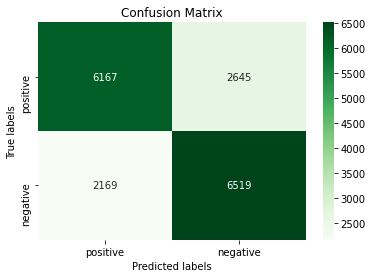

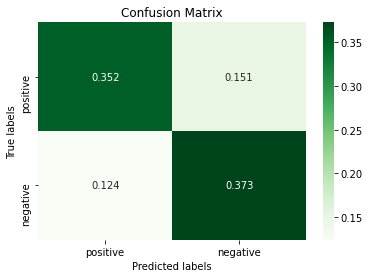

In [38]:
original_rf, X_cols,X_train, X_test, y_train, y_test = train_model(dataset)
plot_confusion_matrix(y_test, original_rf.predict(X_test[X_cols]))
plot_confusion_matrix(y_test, original_rf.predict(X_test[X_cols]),return_percentage=True)

confusion matrix for women in test


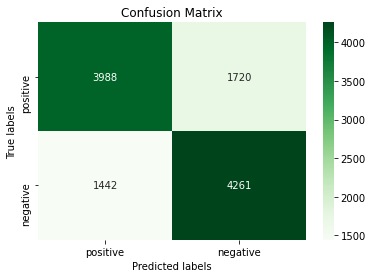

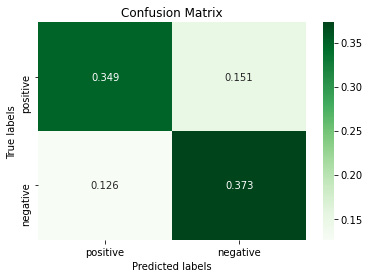

confusion matrix for men in test


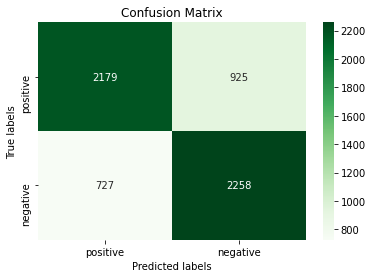

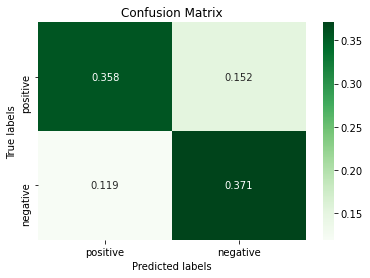

In [8]:
women_test_idx = (X_test['gender']==1)
men_test_idx = (X_test['gender']==2)
print('confusion matrix for women in test')
plot_confusion_matrix(y_test[women_test_idx], original_rf.predict(X_test[X_cols][women_test_idx]))
plot_confusion_matrix(y_test[women_test_idx], original_rf.predict(X_test[X_cols][women_test_idx]),return_percentage=True)
print('confusion matrix for men in test')
plot_confusion_matrix(y_test[men_test_idx], original_rf.predict(X_test[X_cols][men_test_idx]))
plot_confusion_matrix(y_test[men_test_idx], original_rf.predict(X_test[X_cols][men_test_idx]),return_percentage=True)

### Place your disparate impact and equal opportunity difference measurements here

In [20]:
tpr_women= 3988 / (3988 + 1720)
#print(tpr_women)
tpr_men= 2179 / (2179 + 925)
#print(tpr_men)

disparate_impact = tpr_women / tpr_men
print("disparate impact = {}".format(disparate_impact))

equal_opportunity_difference = tpr_women - tpr_men
print("equal_opportunity_difference = {}".format(equal_opportunity_difference))

disparate impact = 0.9952579779014374
equal_opportunity_difference = -0.003328887291484506


## Introducing gender bias into data 

We can introduce gender bias into the data by manipulating the ratio of positive to negative events for either gender. In this case, we will alter the dataset by removing a percentage% of the occurrences where women have cardiovascular disease. In other words, on the altered data, women will have a lower likelihood of cardiovascular disease.

Code is provided to do the following steps:

 - Create the biased dataset using the generate_biased_dataset helper function. **By default, 40% of cardiac events for women are removed, creating a gender imbalance**.
 - Train a model based on this biased dataset using the train_model helper function
 - Create a confusion matrix using the plot_confusion_matrix helper function
 - Create a confusion matrix for the subset of the test set where the gender is male, and a confusion matrix for the subset of the test set where gender is female.

Based on the confusion matrices generated above, you are asked to:
 - Manually measure the disparate impact by dividing the ratio of positive predictions for females by the ratio of positive predictions for males. There should be negligible bias (disparate impact is close to 1).
 - Manually measure the equal opportunity difference by subtrating the true positive rate for females, from the true positive rate for males (there should be a difference around 10%)


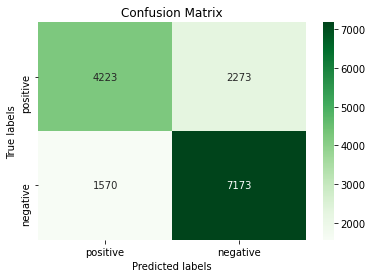

In [40]:
biased_dataset = generate_biased_dataset(dataset, women_yes_event_subsample_rate = 0.6)

biased_rf, X_cols,X_train, X_test, y_train, y_test = train_model(biased_dataset)
plot_confusion_matrix(y_test, biased_rf.predict(X_test[X_cols]))

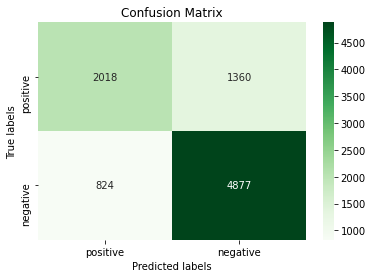

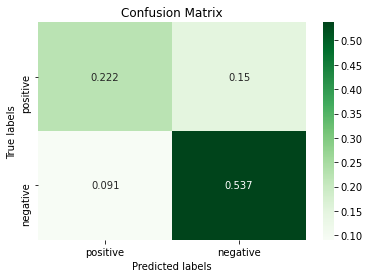

In [13]:
women_test_idx = (X_test['gender']==1)
men_test_idx = (X_test['gender']==2)

plot_confusion_matrix(
    y_test[women_test_idx], 
    biased_rf.predict(X_test[X_cols][women_test_idx]))

plot_confusion_matrix(
    y_test[women_test_idx], 
    biased_rf.predict(X_test[X_cols][women_test_idx]),return_percentage=True)

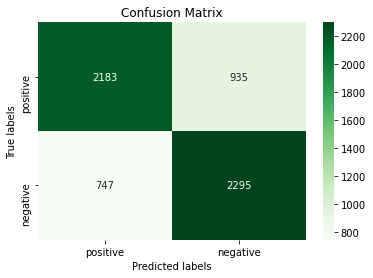

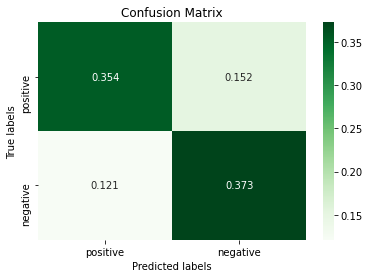

In [14]:
plot_confusion_matrix(
    y_test[men_test_idx], 
    biased_rf.predict(X_test[X_cols][men_test_idx]),)
plot_confusion_matrix(
    y_test[men_test_idx], 
    biased_rf.predict(X_test[X_cols][men_test_idx]),return_percentage=True)

### Place your disparate impact and equal opportunity difference measurements here¶

In [71]:
tpr_women= 2018 / (2018 + 1360)
#print(tpr_women)
tpr_men= 2183 / (2183 + 935)
#print(tpr_men)

disparate_impact = tpr_women / tpr_men
print("disparate impact = {}".format(disparate_impact))

equal_opportunity_difference = tpr_women - tpr_men
print("equal_opportunity_difference = {}".format(equal_opportunity_difference))

disparate impact = 0.8532649216034229
equal_opportunity_difference = -0.10273337913397296


## Diagnosing gender bias in the model using SHAP

 - It is relatively simple to show that the model is considering gender by creating a SHAP summary plot, as we learnt in milestone 1. 
 - If we were looking at this model for the first time, without prior knowledge that it had gender bias, seeing gender as a very important feature would be a red flag.
 - It is not possible to determine from the SHAP plot if the gender feature is given high importance because of genuine physiological differences, or if unwanted algorithmic bias is present.

Generate a SHAP summary plot explaining the biased model. You learned this process in Milestone 1, but there is one difference here, because you are interpreting a classifier instead of a regressor.

Regressor: `shap.summary_plot(shap_values, X_test[:50])`

Classifier: `shap.summary_plot(shap_values[1], X_test[:50])`

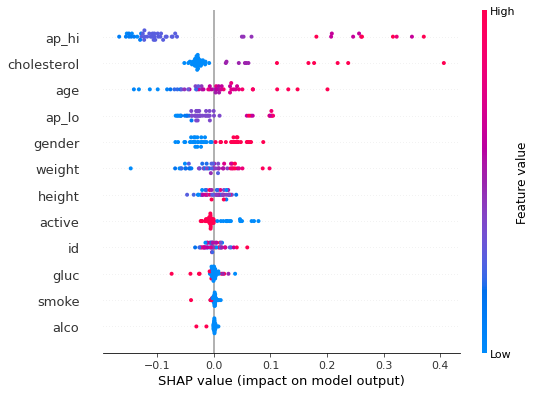

In [24]:
explainer = shap.TreeExplainer(biased_rf)
shap_values = explainer.shap_values(X_test[:50])
shap.summary_plot(shap_values[1], X_test[:50])

## Why can't we just remove the 'gender' variable'?
An interesting question: If the SHAP value is indicating that the 'gender' variable has some importance, and we don't want it to be a source of bias, could we simply remove it rather than going through a time-consuming debiasing process? 

Unfortunately, it is usually not so simple. In this instance, like many others, the model will be able to approximate gender using other variables. Removing the variable also can reduce the accuracy of the model. 

As an optional exercise, if you are curious, you can train a model without the 'gender' variable and confirm that removing the gender variable does not resolve all the algorithmic bias issues. You can pass in __exclude_gender=True__ to the train_model helper function. Repeat the previous process of generating confusion matrices and manually calculating disparate impact and equal opportunity difference. Though there is less bias, it is not removed.



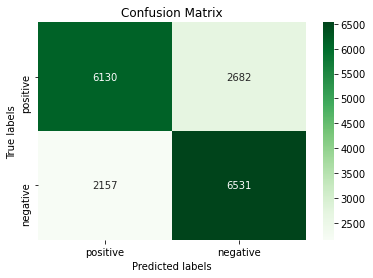

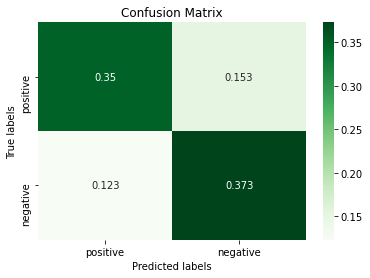

In [32]:
gender_excluded_rf, X_cols,X_train, X_test, y_train, y_test = train_model(dataset, exclude_gender=True)
plot_confusion_matrix(y_test, gender_excluded_rf.predict(X_test[X_cols]))
plot_confusion_matrix(y_test, gender_excluded_rf.predict(X_test[X_cols]),return_percentage=True)

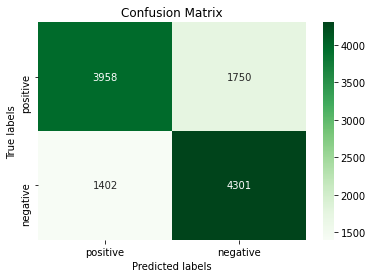

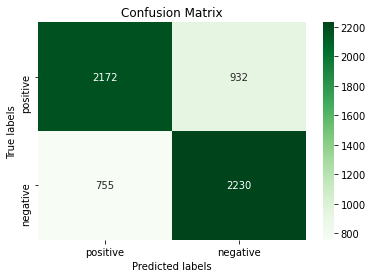

In [34]:
women_test_idx = (X_test['gender']==1)
men_test_idx = (X_test['gender']==2)

plot_confusion_matrix(
    y_test[women_test_idx], 
    gender_excluded_rf.predict(X_test[X_cols][women_test_idx]))

plot_confusion_matrix(
    y_test[men_test_idx], 
    gender_excluded_rf.predict(X_test[X_cols][men_test_idx]),)

In [36]:
tpr_women= 3958 / (3958 + 1750)
#print(tpr_women)
tpr_men= 2172 / (2172 + 932)
#print(tpr_men)

disparate_impact = tpr_women / tpr_men
print("disparate impact = {}".format(disparate_impact))

equal_opportunity_difference = tpr_women - tpr_men
print("equal_opportunity_difference = {}".format(equal_opportunity_difference))

disparate impact = 0.9909545066792625
equal_opportunity_difference = -0.006329514011804704


# Debiasing our model with AIF360

We have now manually observed bias which might be unwanted. We should nail down exactly what these biases are. There are at least two obvious biases in the model we built:
 1. Due directly to our tampering with the dataset, the model predicts more positive cases for men than women. **The relevant bias metric here is disparate impact.**
 2. The model's errors are distributed unevenly across genders: women have a lower true positive rater than men. **The relevant bias metric here is equal opportunity difference.**

The question remains which of these biases are unwanted algorithmic biases, and how we could mitigate them 

1. In this milestone, we artifically caused disparate impact **(1)**. However, disparities between men and women can be due to general physiological differences (for example, breast cancer is [70-100 times less common in men than in women](https://www.cancer.org/cancer/breast-cancer-in-men/about/key-statistics.html). With more knowledge about the experimental setup, a subject matter expert in cardiovascular disease would be able to give a qualified answer about the source of the bias and whether or not it's unwanted. For learning purposes, we will assume that this bias is unwanted and attempt to remove it.

2. The uneven distribution of errors **(2)** is more straightforward. The model errors are unfairly distributed in such a way that borderline cases in women are more likely to be judged as negative than borderline cases in men. If we can resolve this without a substantial drop in overall accuracy, that would usually be the correct choice.

For learning purposes, we will attempt to mitigate both types of bias. 

# Debiasing steps
 - Load train and test datasets into AIF360
 - Using ClassificationMetric, measure key bias metrics (accuracy, disparate impact, equal opportunity difference) in the biased model's predictions
 - Use each of the following debias methods 
  - a pre-processing debiasing method (eg reweighing), 
  - a processing debiasing method (eg prejudice remover)
  - a post-processing debiasing method (eg calibration)
 - Decide on a preferred debiasing approach
 - Using your reweighing dataset, 
 
For demonstration purposes, the below cell contains an audit of accuracy, statistical parity difference, and disparate impact, with respect to the model and the biased dataset. You can modify the code to report on relevant metrics for each debiasing method you choose to test.

### Load biased dataset into AIF360

In [41]:
aif360_biased_dataset_train = pandas_to_aif360(pd.concat([X_train, y_train], axis=1)) #this is a helper function, you could insetad use the below
# aif360_biased_dataset = aif360.datasets.BinaryLabelDataset(1,0,df=pd.concat([X_train, y_train], axis=1),label_names=['cardio'],protected_attribute_names=['gender'])
aif360_biased_dataset_test = pandas_to_aif360(pd.concat([X_test, y_test], axis=1))
results = {}

### Understanding AIF360 Datasets and ClassificationMetrics

For our purposes, AIF360 BinaryLabelDatasets have four key components:


| Component  | Code  | Description  | 
| --- | --- | ---
| Features | BinaryLabelDataset.features  |  features (usually inputs to a model).
| Scores  | BinaryLabelDataset.scores |  probability of a positive event.
| Labels  | BinaryLabelDataset.labels  | record of a positive event. Can be 1 or 0. 
| Weights  | BinaryLabelDataset.instance_weights  | when using Reweighing, instance weights will be placed here.

When we run an inference over the dataset, we replace both the scores and the labels with the model's prediction over the dataset's features.

When we measure bias metrics with ClassificationMetric, we generally need to pass in two BinaryLabelDataset objects. The first object will be the original dataset, the second will be the dataset which has had some inference run on it.

### Measure key bias metrics using the original model to predict on the test set

 - Here we want to measure our key bias metrics (equal opportunity difference and disparate impact), as well as measure accuracy and precision in general, with AIF-360.
 - This serves both to confirm the manual measurements you already made and to serve as a benchmark for each debiasing method we will try.

In [42]:
dataset_pred = aif360_biased_dataset_test.copy()
dataset_pred.labels = biased_rf.predict(aif360_biased_dataset_test.features)
dataset_pred.scores = biased_rf.predict_proba(aif360_biased_dataset_test.features)[:,1]

unprivileged_groups = [{'gender':1.0}] #women
privileged_groups = [{'gender':2.0}] #men

metric = ClassificationMetric(
        aif360_biased_dataset_test, dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)

results['original_model'] = {'accuracy':metric.accuracy(),
                               'precision':metric.precision(),
                               'eq_diff': metric.equal_opportunity_difference(),
'disparate_impact':metric.disparate_impact()}

In [43]:
results

{'original_model': {'accuracy': 0.7478180983004135,
  'precision': 0.7289832556533747,
  'eq_diff': -0.0937536434484767,
  'disparate_impact': 0.6754504618756393}}

## Preprocessing the data using Reweighing

Reweighing works by assigning weights to each row in the train dataset, such that the proportion of (group, outcome) is equal. A model can be then trained on the reweighed train dataset and tested on the test dataset without any reweighing. The steps are as follows:

 - Initialize reweighing object
 - Using fit_transform, create a reweighed train dataset from aif360_biased_dataset_train
 - Create a new model (eg RF) and train it on the reweighed train dataset
 - Use the new model to predict on the test dataset
 - Using ClassificationMetric, evalutae performance on the test dataset

In [44]:
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups) #initialize reweighing object
reweighed_dataset = RW.fit_transform(aif360_biased_dataset_train) #create reweighed train dataset

#train new model on reweighed dataset
reweighed_rf = RandomForestClassifier(random_state=42) 
reweighed_rf.fit(reweighed_dataset.features, reweighed_dataset.labels.ravel(), sample_weight=reweighed_dataset.instance_weights)

#infer on the test dataset using new model
reweighing_test = aif360_biased_dataset_test.copy()
reweighing_test.scores = reweighed_rf.predict_proba(aif360_biased_dataset_test.features)[:,1]
reweighing_test.labels = reweighed_rf.predict(aif360_biased_dataset_test.features) 

metric = ClassificationMetric(
        aif360_biased_dataset_test, reweighing_test,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)

results['reweigher'] = {'accuracy':metric.accuracy(),
                        'precision':metric.precision(),
                        'eq_diff': metric.equal_opportunity_difference(),
                        'disparate_impact':metric.disparate_impact()} 

In [45]:
results

{'original_model': {'accuracy': 0.7478180983004135,
  'precision': 0.7289832556533747,
  'eq_diff': -0.0937536434484767,
  'disparate_impact': 0.6754504618756393},
 'reweigher': {'accuracy': 0.7450620119430409,
  'precision': 0.7270039993044688,
  'eq_diff': -0.07658296087083494,
  'disparate_impact': 0.6959349929104556}}

## Preprocessing the data using Disparate Impact Remover

Disparate Impact Remover works by dividing the training set according to protected class and ensuring that the features in all divisions have similar distributions. A model can be then trained on the altered train dataset and tested on the unchanged test dataset. The steps are as follows:

 - Initialize Disparate Impact Remover object (you need to pass in the 'sensitive_attribute' and repair level)
 - Using fit_transform, create an altered train dataset from aif360_biased_dataset_train
 - Create a new model (eg RF) and train it on the reweighed train dataset
 - Use the new model to predict on the test dataset
 - Using ClassificationMetric, evalutae performance on the test dataset
 
This pipeline is very similar to the Reweighing pipeline. Use the Reweighing pipeline code as a guide to implement this part.

In [47]:
DIR = DisparateImpactRemover(repair_level=1.0, sensitive_attribute='gender')
dir_dataset = DIR.fit_transform(aif360_biased_dataset_train)

#train new model on reweighed dataset
dir_rf = RandomForestClassifier(random_state=42) 
dir_rf.fit(dir_dataset.features, dir_dataset.labels.ravel())

#infer on the test dataset using new model
dir_test = aif360_biased_dataset_test.copy()
dir_test.scores = dir_rf.predict_proba(aif360_biased_dataset_test.features)[:,1]
dir_test.labels = dir_rf.predict(aif360_biased_dataset_test.features) 

metric = ClassificationMetric(
        aif360_biased_dataset_test, dir_test,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)

results['DI'] = {'accuracy':metric.accuracy(),
                 'precision':metric.precision(),
                 'eq_diff': metric.equal_opportunity_difference(),
                 'disparate_impact':metric.disparate_impact()} 

In [48]:
results

{'original_model': {'accuracy': 0.7478180983004135,
  'precision': 0.7289832556533747,
  'eq_diff': -0.0937536434484767,
  'disparate_impact': 0.6754504618756393},
 'reweigher': {'accuracy': 0.7450620119430409,
  'precision': 0.7270039993044688,
  'eq_diff': -0.07658296087083494,
  'disparate_impact': 0.6959349929104556},
 'DI': {'accuracy': 0.7468994028479559,
  'precision': 0.7245957446808511,
  'eq_diff': -0.04051590660771076,
  'disparate_impact': 0.7497167760565336}}

<!-- ## In-processing debiasing using Prejudice Remover

Prejudice Remover trains a model with a regularization term to penalize discrimination along protected-class lines. For this method, the original model is not necessary. The steps are as follows:

 - Initialize PrejudiceRemover object
 - Train the PrejudiceRemover on the train dataset
 - Use the PrejudiceRemover to predict on the test dataset
 - Using ClassificationMetric, evaluatee performance on the test dataset
 -->

## Post-processing debiasing using Calibrated Equal Odds Postprocessing

Calibrated Equal Odds Postprocessing adds an additional objective for regions of the model's prediction which carry high differences in odds between the protected and unprotected class members. The steps are as fllows:

 - Use the original model to predict on both the train and test sets
 - Initialize the CalibratedEqOddsPostprocessing object 
 - Train the postprocessor on the model's predictions for the train dataset
 - Run the postprocessor on the model's predictions for the test dataset
 - Using ClassificationMetric, evaluate the performance of the postprocessor

In [49]:
postprocessor = CalibratedEqOddsPostprocessing(unprivileged_groups, privileged_groups)
dataset_pred_train = aif360_biased_dataset_train.copy()
dataset_pred_test = aif360_biased_dataset_test.copy()
dataset_pred_train.labels = biased_rf.predict(aif360_biased_dataset_train.features)
dataset_pred_train.scores = biased_rf.predict_proba(aif360_biased_dataset_train.features)[:,1]
dataset_pred_test.labels = biased_rf.predict(aif360_biased_dataset_test.features)
dataset_pred_test.scores = biased_rf.predict_proba(aif360_biased_dataset_test.features)[:,1]

postprocessor.fit(aif360_biased_dataset_train, dataset_pred_train)

postprocessed = postprocessor.predict(dataset_pred_test)

metric = ClassificationMetric(
        aif360_biased_dataset_test, postprocessed,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)

results['post-calibration'] = {'accuracy':metric.accuracy(),
                               'precision':metric.precision(),
                                'eq_diff': metric.equal_opportunity_difference(),
                                'disparate_impact':metric.disparate_impact()}


## Summarize your results
Review the accuracy, precision, equal opportunity difference, and disparate impact for the original model and each debiasing method. Does debiasing make a difference? Is there a large tradeoff between accuracy/precision and the debiasing process? 

In [50]:
pd.DataFrame(results).T

,accuracy,precision,eq_diff,disparate_impact
original_model,0.747818,0.728983,-0.093754,0.675450
reweigher,0.745062,0.727004,-0.076583,0.695935
DI,0.746899,0.724596,-0.040516,0.749717
post-calibration,0.744603,0.722412,-0.107396,0.661549


### Threshold Selection

The output of both Reweighing and Disparate Impact Removers is a new classifier object. These classifiers can be fine-tuned further by selecting a threshold.

The default threshold for scikit-learn classifiers is 0.5 . The classifier's binary output represents an expected probability either below or above/equal this theshold. We can manipulate the threshold if we see that a different threshold shows improved results.

When debiasing, threshold selection is especially important, because it gives data scientists a sense of how much model performance could be sacrificed to reach a certain bias measure (eg >0.8 Disparate Impact). If the sacrifice to model performance is low, an alternate threshold with better bias metrics could be chosen. 

Below you are provided some sample code which evaluates each percentage threshold from 0% to 100% for the original biased model and Reweighing model. You are asked to do the following:

 - Run the code to evaluate each percentage threshold
 - Add additional code to evaluate the percentage thresholds for the Reweighing model
 - Observe the shifts in accuracy, precision, disparate impact and average odds difference across each threshold
 - Is it possible to say which model, provides the best performance and at which threshold? Would you recommend a non-default threshold for your preferred model? Refer to the resource on impossibility for an explanation of why one threshold will not maximize all metrics.

In [51]:
reports = []
pd.set_option('display.max_rows', 1000)
for thresh in np.linspace(0,1,101):
    #apply new threshold
    dataset_pred.labels = dataset_pred.scores>=thresh 
    reweighing_test.labels = reweighing_test.scores>=thresh
    
    #get bias and acccuracy metrics
    metric_original_rf = ClassificationMetric(
        aif360_biased_dataset_test, dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
    
    metric_reweighed_rf = ClassificationMetric(
        aif360_biased_dataset_test, reweighing_test,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)

    #record metrics
    reports.append((thresh, 
          metric_original_rf.accuracy(), 
          metric_original_rf.average_odds_difference(),
          metric_original_rf.disparate_impact(),
          metric_reweighed_rf.accuracy(), 
          metric_reweighed_rf.average_odds_difference(),
          metric_reweighed_rf.disparate_impact()))

report_df = pd.DataFrame(reports)
report_df.columns = ['threshhold','accuracy_original',
                     'average_odds_difference_original',
                     'disparate_impact_original',
                     'accuracy_reweighed',
                     'average_odds_difference_reweighed',
                     'disparate_impact_reweighed']
display(report_df.set_index('threshhold'))

invalid value encountered in double_scalars


,accuracy_original,average_odds_difference_original,disparate_impact_original,accuracy_reweighed,average_odds_difference_reweighed,disparate_impact_reweighed
threshhold,,,,,,
0.00,0.426275,0.000000,1.000000,0.426275,0.000000,1.000000
0.01,0.428046,-0.001954,0.997454,0.428900,-0.003947,0.995256
0.02,0.432443,-0.006684,0.991408,0.433493,-0.009533,0.988236
0.03,0.439530,-0.015790,0.980101,0.440449,-0.015163,0.980568
0.04,0.448455,-0.025920,0.967337,0.447995,-0.020526,0.973049
0.05,0.456854,-0.034949,0.955779,0.457379,-0.030580,0.959993
0.06,0.467025,-0.041260,0.946257,0.466894,-0.038614,0.948987
0.07,0.478378,-0.051548,0.932316,0.476803,-0.043988,0.940805
0.08,0.488024,-0.061044,0.919437,0.486974,-0.052962,0.928524


According to section 4.7 on impossibility it's not possible to optimize the performance in all metrics. So it's a tradeoff i.e. based on the use case you have to decide which metrics should be optimized.
In context of predicting 'Cardiovascular Diseases' optimizing the accuracy is preferable. So maybe the reweighed model at threshold 0.52 seems to be a good tradeoff.

In [67]:
report_df.iloc[report_df['accuracy_original'].argmax()][['accuracy_original','average_odds_difference_original','disparate_impact_original']]

accuracy_original                   0.749393
average_odds_difference_original   -0.080108
disparate_impact_original           0.676707
Name: 55, dtype: float64

In [68]:
report_df.iloc[50][['accuracy_original','average_odds_difference_original','disparate_impact_original']]

accuracy_original                   0.746703
average_odds_difference_original   -0.093537
disparate_impact_original           0.677573
Name: 50, dtype: float64

In [69]:
report_df.iloc[report_df['accuracy_reweighed'].argmax()][['accuracy_reweighed','average_odds_difference_reweighed','disparate_impact_reweighed']]

accuracy_reweighed                   0.746834
average_odds_difference_reweighed   -0.079078
disparate_impact_reweighed           0.691103
Name: 52, dtype: float64

In [70]:
report_df.iloc[50][['accuracy_reweighed','average_odds_difference_reweighed','disparate_impact_reweighed']]

accuracy_reweighed                   0.744537
average_odds_difference_reweighed   -0.081085
disparate_impact_reweighed           0.697888
Name: 50, dtype: float64

## Complete the deliverable

This notebook, complete with your reflections, is your deliverable.